In [141]:
 # This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from  sklearn.metrics import mean_squared_error

# I transformed the txt files into csv just because they are a bit simpler to manage
# added the title row at the beginning: "time" "velocity" "force"
# I use only numerical_data.csv to train, and experimental_data.csv to test the model,
# If you think that it is better you can merge the files (but then you will have to find other data
# to test th model), or swap them (train with experimental and test with numerical data)

train = pd.read_csv("numerical_data.csv", sep=",")

# INPUT:  ONLY VELOCITY
# OUTPUT: ONLY FORCE
# change this value to N if you want to use N previous values
timestep = 1  # for Reshape_input etc.

# with timestep = 10, relu and scaled data I found:
# MSE 2.7140929919153043e-06 for train scaled values
# MSE 0.0016335511228334893 for train scaled back values
# MSE 1.2209993163934232e-05 for test scaled values
# MSE 0.010834463731322736 for test scaled back values

In [142]:
 train.shape

(30001, 3)

In [143]:
train.head() 

,time,velocity,force
0,0.000,0.000000e+00,-0.000017
1,0.001,-7.040000e-09,-0.000017
2,0.002,-7.650000e-05,0.006806
3,0.003,-2.157000e-04,0.019206
4,0.004,-4.113000e-04,0.036630


In [144]:
 train.dtypes

time        float64
velocity    float64
force       float64
dtype: object

In [145]:
train.corr()


,time,velocity,force
time,1.00000,-0.014960,0.014950
velocity,-0.01496,1.000000,-0.999996
force,0.01495,-0.999996,1.000000


In [146]:
#from sklearn.preprocessing import StandardScaler

In [147]:
#from sklearn.preprocessing import MinMaxScaler

In [148]:
#enc1=MinMaxScaler(feature_range=(0,1))
# I added explicitly the range even if it's default


In [149]:
def Reshape_input(train,transform_only):
    # timestep = 10 moved outside, so if you change it you can adjust everything
    
    # I applied transform to y too
    # Important points about LSTM models:
    # - they predict time series: given n measures (e.g. 10 ) at time t1...tn 
    #     they compute pred. measure at time tn+1 (e.g. at t=11)
    # - so the "features" are the n measures and the "label" is the n+1th measure (sliding along the data)
    # - quite often they are used with time series consisting of 1 measure only, but we have 2 
    #     (velocity and force)
    # - so we have to use a 2-dimensional time series, and also velocities will be predicted...
    
    #X ,y = train.iloc[:,:1],train.iloc[timestep:,2]
#    X = train.iloc[:,1:]
    X = np.array(train.iloc[:,1:])
    #print(X.shape)
    #if transform_only:
    #    X= enc1.transform(X)
    #else:
    #    X= enc1.fit_transform(X)
#    X_3d = np.zeros((X.shape[0]-timestep,timestep,X.shape[1]))
#    y = np.zeros((X.shape[0]-timestep,X.shape[1]))
    X_3d = np.zeros((X.shape[0]-timestep,timestep,1))
    y = np.zeros((X.shape[0]-timestep,1))
    print(X_3d.shape)
    
    for i in range(X_3d.shape[0]):
        X_3d[i,:,0] = X[i:i+timestep,0]
        y[i,0] = X[i+timestep,1]
    #return enc1, X_3d, y
    return X_3d, y


In [150]:
X, y = Reshape_input(train,transform_only=False)

(30000, 1, 1)


In [151]:
X.shape

(30000, 1, 1)

In [152]:
print(X[:20]) # to see that actually the 10 values of velocity "slide"

[[[ 0.0000e+00]]

 [[-7.0400e-09]]

 [[-7.6500e-05]]

 [[-2.1570e-04]]

 [[-4.1130e-04]]

 [[-6.6100e-04]]

 [[-9.6430e-04]]

 [[-1.3213e-03]]

 [[-1.7325e-03]]

 [[-2.1985e-03]]

 [[-2.7196e-03]]

 [[-3.2960e-03]]

 [[-3.9279e-03]]

 [[-4.6151e-03]]

 [[-5.3576e-03]]

 [[-6.1551e-03]]

 [[-7.0074e-03]]

 [[-7.9140e-03]]

 [[-8.8739e-03]]

 [[-9.8853e-03]]]


In [153]:
y.shape

(30000, 1)

In [154]:
print(y[:20])  # this is force, nothing to do with the X values

[[-1.6600000e-05]
 [ 6.8062400e-03]
 [ 1.9205700e-02]
 [ 3.6630020e-02]
 [ 5.8868160e-02]
 [ 8.5876540e-02]
 [ 1.1769623e-01]
 [ 1.5441354e-01]
 [ 1.9613591e-01]
 [ 2.4296408e-01]
 [ 2.9494680e-01]
 [ 3.5201779e-01]
 [ 4.1394206e-01]
 [ 4.8034338e-01]
 [ 5.5091283e-01]
 [ 6.2581758e-01]
 [ 7.0601744e-01]
 [ 7.9279531e-01]
 [ 8.8615588e-01]
 [ 9.8361402e-01]]


In [155]:
from keras.models import Sequential
from keras.layers import *
from keras.layers import LSTM
from keras.layers import Activation
from keras.optimizers import Adam, SGD
from keras.callbacks import *
model = Sequential()
# I did not change the model here, just make some small experiments. 
# Probably you should compare the model and parameters to the ones you used in Matlab, and tune them a bit...
# I tried also with recurrent_dropout = 0.1 (no better results)
model.add(LSTM(18, input_shape=(X.shape[1], X.shape[2]), recurrent_dropout= 0))
# From your messages I'd expect only the LSTM and one Dense for output, but I did not change here
model.add(Dense(18,kernel_initializer='normal',activation='tanh'))
model.add(Dropout(0))
# Here we need 2 because our data are velocity AND force!
model.add(Dense(1))
model.add(Dense(1,activation='linear'))
# Iadded explicit lr to Adam optimizer, tried several values and 
#   varied also min_lr accordingly in ReduceRLOnPlateau; 
# I tried also with SGD (no better results)
model.compile(Adam(lr=0.001), loss='mean_squared_error')

checkpoint = ModelCheckpoint(filepath='model_lstm_yusra_weights.hdfs', save_weights_only=True,
                             monitor='val_loss',save_best_only=True)
EarlyStop = EarlyStopping(monitor='val_loss', min_delta=0, patience=4,
                          verbose=0, mode='auto')
# tried also with smaller min_lr
RL = ReduceLROnPlateau(min_lr=0.00001,factor=0.3,patience=3)

In [156]:
# tried with batch sizes 32, 64, 512, etc.; validation_split=0.2
history = model.fit(X, y, epochs=500, batch_size=32,validation_split=0.25,
                  verbose=1, shuffle=False,callbacks=[checkpoint,RL,EarlyStop])

Train on 22500 samples, validate on 7500 samples
Epoch 1/500
22500/22500 [==============================] - 2s 97us/step - loss: 10.5763 - val_loss: 8.6180
Epoch 2/500
22500/22500 [==============================] - 1s 44us/step - loss: 7.1359 - val_loss: 2.2037
Epoch 3/500
22500/22500 [==============================] - 1s 48us/step - loss: 0.5721 - val_loss: 0.0268
Epoch 4/500
22500/22500 [==============================] - 1s 44us/step - loss: 0.0314 - val_loss: 0.0249
Epoch 5/500
22500/22500 [==============================] - 1s 46us/step - loss: 0.0325 - val_loss: 0.0258
Epoch 6/500
22500/22500 [==============================] - 1s 45us/step - loss: 0.0324 - val_loss: 0.0257
Epoch 7/500
22500/22500 [==============================] - 1s 45us/step - loss: 0.0321 - val_loss: 0.0220
Epoch 8/500
22500/22500 [==============================] - 1s 45us/step - loss: 0.0320 - val_loss: 0.0205
Epoch 9/500
22500/22500 [==============================] - 1s 45us/step - loss: 0.0316 - val_loss: 0.0

22500/22500 [==============================] - 1s 44us/step - loss: 0.0094 - val_loss: 0.0067
Epoch 78/500
22500/22500 [==============================] - 1s 43us/step - loss: 0.0094 - val_loss: 0.0067
Epoch 79/500
22500/22500 [==============================] - 1s 46us/step - loss: 0.0093 - val_loss: 0.0066
Epoch 80/500
22500/22500 [==============================] - 1s 47us/step - loss: 0.0093 - val_loss: 0.0066
Epoch 81/500
22500/22500 [==============================] - 1s 44us/step - loss: 0.0092 - val_loss: 0.0065
Epoch 82/500
22500/22500 [==============================] - 1s 43us/step - loss: 0.0092 - val_loss: 0.0065
Epoch 83/500
22500/22500 [==============================] - 1s 44us/step - loss: 0.0091 - val_loss: 0.0065
Epoch 84/500
22500/22500 [==============================] - 1s 43us/step - loss: 0.0090 - val_loss: 0.0064
Epoch 85/500
22500/22500 [==============================] - 1s 45us/step - loss: 0.0090 - val_loss: 0.0064
Epoch 86/500
22500/22500 [========================

22500/22500 [==============================] - 1s 44us/step - loss: 0.0060 - val_loss: 0.0057
Epoch 154/500
22500/22500 [==============================] - 1s 44us/step - loss: 0.0060 - val_loss: 0.0057
Epoch 155/500
22500/22500 [==============================] - 1s 43us/step - loss: 0.0060 - val_loss: 0.0057
Epoch 156/500
22500/22500 [==============================] - 1s 45us/step - loss: 0.0060 - val_loss: 0.0057
Epoch 157/500
22500/22500 [==============================] - 1s 44us/step - loss: 0.0060 - val_loss: 0.0057
Epoch 158/500
22500/22500 [==============================] - 1s 45us/step - loss: 0.0060 - val_loss: 0.0057
Epoch 159/500
22500/22500 [==============================] - 1s 43us/step - loss: 0.0060 - val_loss: 0.0057
Epoch 160/500
22500/22500 [==============================] - 1s 43us/step - loss: 0.0060 - val_loss: 0.0057
Epoch 161/500
22500/22500 [==============================] - 1s 44us/step - loss: 0.0060 - val_loss: 0.0057
Epoch 162/500
22500/22500 [===============

Epoch 229/500
22500/22500 [==============================] - 1s 44us/step - loss: 0.0058 - val_loss: 0.0056
Epoch 230/500
22500/22500 [==============================] - 1s 44us/step - loss: 0.0058 - val_loss: 0.0056
Epoch 231/500
22500/22500 [==============================] - 1s 43us/step - loss: 0.0058 - val_loss: 0.0056
Epoch 232/500
22500/22500 [==============================] - 1s 43us/step - loss: 0.0058 - val_loss: 0.0056
Epoch 233/500
22500/22500 [==============================] - 1s 44us/step - loss: 0.0058 - val_loss: 0.0056
Epoch 234/500
22500/22500 [==============================] - 1s 44us/step - loss: 0.0058 - val_loss: 0.0056
Epoch 235/500
22500/22500 [==============================] - 1s 44us/step - loss: 0.0058 - val_loss: 0.0056
Epoch 236/500
22500/22500 [==============================] - 1s 44us/step - loss: 0.0058 - val_loss: 0.0056
Epoch 237/500
22500/22500 [==============================] - 1s 45us/step - loss: 0.0058 - val_loss: 0.0055
Epoch 238/500
22500/22500 [=

Epoch 305/500
22500/22500 [==============================] - 1s 46us/step - loss: 0.0057 - val_loss: 0.0054
Epoch 306/500
22500/22500 [==============================] - 1s 44us/step - loss: 0.0057 - val_loss: 0.0054
Epoch 307/500
22500/22500 [==============================] - 1s 42us/step - loss: 0.0057 - val_loss: 0.0054
Epoch 308/500
22500/22500 [==============================] - 1s 43us/step - loss: 0.0057 - val_loss: 0.0054
Epoch 309/500
22500/22500 [==============================] - 1s 45us/step - loss: 0.0057 - val_loss: 0.0054
Epoch 310/500
22500/22500 [==============================] - 1s 47us/step - loss: 0.0057 - val_loss: 0.0054
Epoch 311/500
22500/22500 [==============================] - 1s 46us/step - loss: 0.0057 - val_loss: 0.0054
Epoch 312/500
22500/22500 [==============================] - 1s 42us/step - loss: 0.0057 - val_loss: 0.0054
Epoch 313/500
22500/22500 [==============================] - 1s 44us/step - loss: 0.0057 - val_loss: 0.0054
Epoch 314/500
22500/22500 [=

Epoch 381/500
22500/22500 [==============================] - 1s 44us/step - loss: 0.0056 - val_loss: 0.0053
Epoch 382/500
22500/22500 [==============================] - 1s 43us/step - loss: 0.0056 - val_loss: 0.0053
Epoch 383/500
22500/22500 [==============================] - 1s 44us/step - loss: 0.0056 - val_loss: 0.0053
Epoch 384/500
22500/22500 [==============================] - 1s 44us/step - loss: 0.0056 - val_loss: 0.0053
Epoch 385/500
22500/22500 [==============================] - 1s 49us/step - loss: 0.0056 - val_loss: 0.0053
Epoch 386/500
22500/22500 [==============================] - 1s 44us/step - loss: 0.0056 - val_loss: 0.0053
Epoch 387/500
22500/22500 [==============================] - 1s 44us/step - loss: 0.0056 - val_loss: 0.0053
Epoch 388/500
22500/22500 [==============================] - 1s 43us/step - loss: 0.0056 - val_loss: 0.0053
Epoch 389/500
22500/22500 [==============================] - 1s 43us/step - loss: 0.0056 - val_loss: 0.0053
Epoch 390/500
22500/22500 [=

Epoch 457/500
22500/22500 [==============================] - 1s 43us/step - loss: 0.0055 - val_loss: 0.0052
Epoch 458/500
22500/22500 [==============================] - 1s 42us/step - loss: 0.0055 - val_loss: 0.0052
Epoch 459/500
22500/22500 [==============================] - 1s 42us/step - loss: 0.0055 - val_loss: 0.0052
Epoch 460/500
22500/22500 [==============================] - 1s 42us/step - loss: 0.0055 - val_loss: 0.0052
Epoch 461/500
22500/22500 [==============================] - 1s 43us/step - loss: 0.0055 - val_loss: 0.0052
Epoch 462/500
22500/22500 [==============================] - 1s 43us/step - loss: 0.0055 - val_loss: 0.0052
Epoch 463/500
22500/22500 [==============================] - 1s 43us/step - loss: 0.0055 - val_loss: 0.0052
Epoch 464/500
22500/22500 [==============================] - 1s 44us/step - loss: 0.0055 - val_loss: 0.0052
Epoch 465/500
22500/22500 [==============================] - 1s 43us/step - loss: 0.0055 - val_loss: 0.0052
Epoch 466/500
22500/22500 [=

In [157]:
pp=model.predict(X) # now we get the prdictions (scaled velocities and forces)

In [159]:
mean_squared_error(pp,y)

# with lr=0.001, 100 steps got 0.005668408342830114
# with lr=0.0005, 300 steps got 0.008107564210159415
# with lr=0.001, 300 steps got 0.005516485598126501
# with lr=0.001, 500 steps got 0.005311465403687944

0.005311465403687944

In [160]:
# scale back and compute mse between force and predicted force
#pp.shape
#pp_back=np.zeros((pp.shape[0],2))
#for i in range(pp.shape[0]):
#    pp_back[i,1] = pp[i]

#pp_back=enc1.inverse_transform(pp_back)
#pp_back.shape
#mean_squared_error(pp_back[:,1],train["force"][timestep:])

# with timestep 10 I got here 0.0016335511228334893

In [161]:
"""Step 2 - Make a dataframe with one  file from  Z=1.5"""

'Step 2 - Make a dataframe with one  file from  Z=1.5'

In [162]:
test = pd.read_csv("experimental_data.csv", sep=",")
# using this file to test the model

In [163]:
test.head()

,time,velocity,force
0,0.000,0.0,0.0
1,0.001,0.0,0.0
2,0.002,0.0,0.0
3,0.003,0.0,0.0
4,0.004,0.0,0.0


In [164]:
test.dtypes

time        float64
velocity    float64
force       float64
dtype: object

In [165]:
X, y = Reshape_input(test,transform_only=False)

(30000, 1, 1)


In [166]:
X.shape

(30000, 1, 1)

In [167]:
print(X[:20])  # check that the input features are the correct ones!

[[[ 0.        ]]

 [[ 0.        ]]

 [[ 0.        ]]

 [[ 0.        ]]

 [[ 0.        ]]

 [[ 0.        ]]

 [[ 0.        ]]

 [[ 0.        ]]

 [[ 0.        ]]

 [[-0.00144894]]

 [[-0.00144894]]

 [[-0.00108671]]

 [[-0.00072447]]

 [[-0.00045279]]

 [[-0.0046185 ]]

 [[-0.00740318]]

 [[-0.0076975 ]]

 [[-0.00729564]]

 [[-0.00826915]]

 [[-0.00934312]]]


In [168]:
y.shape

(30000, 1)

In [169]:
print(y[:20])   # check that the input targets are the correct ones!

[[0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.13038757]
 [0.13038757]
 [0.09779068]
 [0.06519378]
 [0.04074611]
 [0.41561037]
 [0.66619898]
 [0.69268396]
 [0.65652178]
 [0.74412592]
 [0.84077062]
 [0.52435157]]


In [170]:
model.load_weights('model_lstm_yusra_weights.hdfs')

In [171]:
pred1=model.predict(X)
    

In [173]:
mean_squared_error(pred1,y)
# with lr=0.001, 100 steps got 0.01709374798031922
# with lr=0.0005, 300 steps got 0.02122044020938303
# with lr=0.001, 300 steps got 0.016831908782882276
# with lr=0.001, 500 steps got 0.016476083564238492

0.016476083564238492

In [174]:

#pred1_back=np.zeros((pred1.shape[0],2))
#for i in range(pred1.shape[0]):
#    pred1_back[i,1] = pred1[i]

#pred1_back=enc1.inverse_transform(pred1_back)
#pp_back.shape
#mean_squared_error(pred1_back[:,1],test["force"][timestep:])

# with timestep 10 I got here 0.010834463731322736

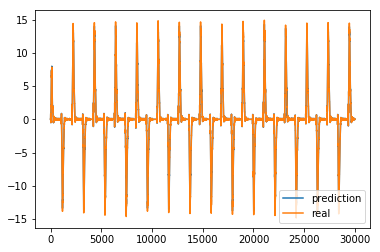

In [175]:
from matplotlib  import pyplot  as plt
fig, ax=plt.subplots()
ax.plot(list(pred1[:]), label='prediction')
ax.plot(list(y[:]), label='real')
plt.legend()
plt.show()

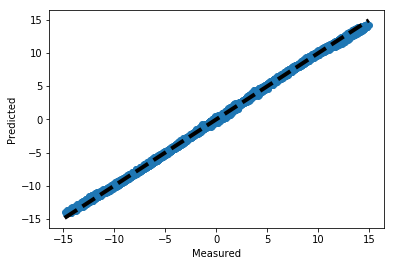

In [176]:
fig, ax=plt.subplots()
ax.scatter(y[:],pred1[:])
ax.plot([y[:].min(), y[:].max()],[y[:].min(), y[:].max()],'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

In [177]:
pred1.shape

(30000, 1)

In [178]:
pd.DataFrame({'real':list(test["force"][timestep:]),'pred':list(pred1[:,0])} ) .to_csv('train_data_lstmyusra1t.csv',index=False)

In [61]:


#model.save('train_data_lstm_yusra.h5')

